In [1]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Activation, Dropout, concatenate)
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import collections
import tensorflow as tf
import time
sys.path.append('./*')
sys.path=list(set(sys.path))

from model.keras_models import create_dense_layers, inst_layers, sampling
from module_DTI.default_load import *
from module_DTI.utils import *

config = collections.namedtuple('config', ['Dataset'])
dict_directories = {'dir_ROOT': './dataset/final', }
dict_directories.update({
    'DTI_adjmat': dict_directories['dir_ROOT'] + '/drug-target_mat.tsv',
    'drug': dict_directories['dir_ROOT'] + '/drug_descriptor.tsv',
    'target': dict_directories['dir_ROOT'] + '/protein_descriptor.tsv'
})
config_Dataset = {
        'dict_directories': dict_directories,
        'neg_to_pos_ratio': 1,
        'split_ratio': 0.8,
        'pos_filename': 'pos_sample.txt',
        'neg_filename': 'neg_sample_1.txt',
}
save_path='./model/model_saved/'
checkpoint_path='./model/model_checkpoints/'
config.Dataset = config_Dataset

Using TensorFlow backend.


In [5]:
opt_verbose_dataset=0
opt_verbose_training=0
opt_loss_loc=0
opt_acc_loc=1
DTI=load_DTI(config,verbose=opt_verbose_dataset)
load_pos_neg_samples(config,DTI)

--------------------------------------------------------
Load DTI data.
--------------------------------------------------------
Load existing positive & negative sample files.
# of positive samples: 9592
# of features of a positive sample: 1627

# of negative samples: 9592
# of features of a negative sample: 1627



# LR

In [12]:
N_label='100'
name_model='LR' 
name_test='10sets_5cv'
opt_save_model='on'
neg_file_list=['0','1','2','3','4']#,'5','6','7','8','9']
epochs=100
label_lr=0.001
if int(N_label)<600:
    batch_size=50
else:batch_size=500
l_model_filename=checkpoint_path+'_'.join([N_label,name_model,name_test])
print(l_model_filename)

./model/model_checkpoints/600_LR_10sets_5cv


500

MODEL: LR
N_label: 100
-----------------------------------------------
neg_sample_0.txt
Load existing positive & negative sample files.
1 cross-validation
Accuracy: 54.0146
AUROC: 0.5604
TPR: 0.6293013555787278
TNR: 0.45099061522419187
PRE: 0.534070796460177
F1: 0.5777884155098133


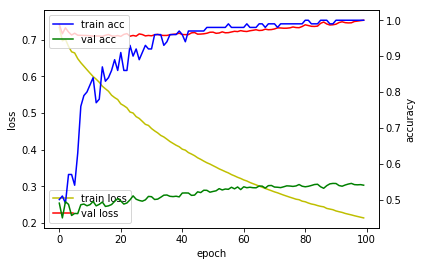

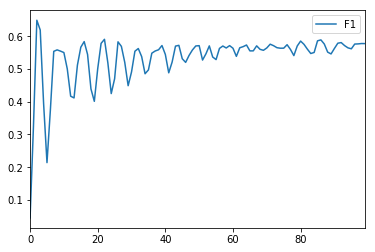

2 cross-validation


KeyboardInterrupt: 

In [9]:
acc_list,auroc_list,TPR_list,TNR_list,PRE_list,F1_list=[],[],[],[],[],[]
print('MODEL: '+name_model[:2])
print('N_label: '+ N_label)
for neg in neg_file_list: 
    print('-----------------------------------------------')   
    config.Dataset['neg_filename']='neg_sample_'+neg+'.txt'
    print(config.Dataset['neg_filename'])
    load_pos_neg_samples(config,DTI,verbose=0)

    rand_ind=np.arange(9592)
    np.random.shuffle(rand_ind)
    for order_CV in range(1,6):
        print(str(order_CV)+' cross-validation')
        train_x,train_y,test_x,test_y=load_train_test_5fold_CV(config,DTI,rand_ind,order_CV)
#     train_x,train_y,test_x,test_y=load_train_test(config,DTI,verbose=opt_verbose_dataset)
        label_train_x,label_train_y = load_label_train_test(train_x,train_y,N_label=N_label,
                                                            stacked_model=None)
        label_test_x=test_x
        label_test_y=test_y
        input_dim=int(np.shape(label_train_x)[1])

        classifier_layers = [
            Dense(2, name='classifier_3'),
            Activation('softmax', name='y_predicted')
        ]
        x_in =Input(shape=(input_dim,), name='x_Input')
        y_output=inst_layers(classifier_layers,x_in)
        optimizer_l = Adam(lr=label_lr)

        classifier=Model(x_in,y_output)
        classifier.compile(optimizer=optimizer_l,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        history_train = []
        history_test = []
        history_test_F1=[]
        
        checkpoint_cls=0.1

        for epoch in range(epochs):
            index = np.arange(len(label_train_x))
            np.random.shuffle(index)
            batches = len(label_train_x) // batch_size
            for i in range(batches):
                index_range =  index[i * batch_size:(i+1) * batch_size]
                loss = classifier.train_on_batch(
                    x=[label_train_x[index_range]],
                    y={'y_predicted': label_train_y[index_range]}
                )
            l = classifier.evaluate(
                x=[label_train_x],
                y={'y_predicted': label_train_y},
                verbose=0)
            l_test = classifier.evaluate(
                x=[label_test_x],
                y={'y_predicted': label_test_y},
                verbose=opt_verbose_training)
            l_test_F1=[float(get_metrics_values(classifier, label_test_x, label_test_y,verbose=0)[6])]
            if opt_save_model=='on' and l_test[opt_acc_loc]>checkpoint_cls:
                checkpoint_cls=l_test[opt_acc_loc]
                classifier.save(l_model_filename+'.h5')
            history_train.append(l) 
            history_test.append(l_test)
            history_test_F1.append(l_test_F1)
        y_pred,accuracy,auroc,TPR,TNR,PRE,F1=get_metrics_values(classifier, label_test_x, label_test_y,verbose=1)
        acc_list.append(accuracy)
        auroc_list.append(auroc)
        TPR_list.append(TPR)
        TNR_list.append(TNR)
        PRE_list.append(PRE)
        F1_list.append(F1)

        #     plot_roc_curve(classifier,label_test_x,label_test_y)
        plot_epoch_acc_loss(np.concatenate((history_train,history_test),axis=1),validation='on')
        plot_epoch(history_test_F1,loc=0,label='F1')
        #     plot_epoch(history_test,loss_loc=opt_loss_loc,label='test_loss')
        #   plot_epoch_loss_w_test(history_train,history_test) 

with open(l_model_filename+'.txt','w') as f:
    acc=[float(v) for v in acc_list]
    auroc=[float(v) for v in auroc_list]
    f1=[float(v) for v in F1_list]
    f.write('Avg acc:\n' + str(np.average(acc)))
    f.write('\nStd acc:\n' + str(np.std(acc)))
    f.write('\nAvg auroc:\n' + str(np.average(auroc)))
    f.write('\nStd auroc:\n' + str(np.std(auroc)))
    f.write('\nAvg F1:\n' + str(np.average(f1)))
    f.write('\nStd acc:\n' + str(np.std(f1)))
    f.write('\nacc\n'+'\n'.join(acc_list))
    f.write('\nauroc\n'+'\n'.join(auroc_list))
    f.write('\nTPR\n'+'\n'.join(TPR_list))
    f.write('\nTNR\n'+'\n'.join(TNR_list))
    f.write('\nPRE\n'+'\n'.join(PRE_list))
    f.write('\nF1\n'+'\n'.join(F1_list))
print('--------------------finish---------------------------')     

In [ ]:
# with open('./model/model_checkpoints/g_LR_loss.txt','w') as f:
#     for k in np.concatenate((history_train,history_test),axis=1):
#         kk='\t'.join([str(v) for v in k])
#         f.write(kk+'\n')
# y_test=[]
# for v in label_test_y:
#     y_test.append(list(v).index(1))
# y_pred = classifier.predict(label_test_x)[:, 1]
# fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
# roc_auc = auc(fpr, tpr)
# with open('./model/model_checkpoints/g_LR_fpr_normal.txt','w') as f:
#     kk=[str(v) for v in list(fpr)]    
#     f.write('\t'.join(list(kk)))
